In [1]:
using EvalMetrics
using Plots

using Pickle
using PyCall
using PrettyTables
using Logging
using Printf

Logging.disable_logging(Logging.Warn)

include("Utils.jl")

label_names = ["Quick Sort", "Merge Sort", "Selection Sort", "Insertion Sort", "Bubble Sort",
    "Linear Search", "Binary Search", "Linked List", "Hashmap"]

9-element Vector{String}:
 "Quick Sort"
 "Merge Sort"
 "Selection Sort"
 "Insertion Sort"
 "Bubble Sort"
 "Linear Search"
 "Binary Search"
 "Linked List"
 "Hashmap"

In [2]:
preds = [Matrix(load_pickle("wce/prediction_$i.pkl")') for i in 0:9]
reals = [Matrix(load_pickle("wce/real_$i.pkl")') for i in 0:9];

targets = hcat(reals...)
predictions = hcat(preds...);

### Confusion Matrix
We create a confusion matrix for each threshold in $[0.25, 0.40, 0.50, 0.60, 0.75]$

In [3]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["True Positive", "True Negative", "False Positive", "False Negative",
    "Recall/Sensitivity", "Precision", "F1-Score", "Accuracy", "Specificity"]
headers = [" ", metrics...]

for threshold ∈ thresholds
    println("Binary Decision Boundary: $threshold")
    
    data = Matrix{Any}(undef, length(label_names), length(headers))
    
    for (idx, label) in enumerate(label_names)
        #ACTUAL POSITIVES, ACTUAL NEGATIVES, TP, TN, FN, FP
        conf = ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
        
        data[idx, 1] = label
        data[idx, 2] = true_positive(conf)
        data[idx, 3] = true_negative(conf)
        data[idx, 4] = false_positive(conf)
        data[idx, 5] = false_negative(conf)
        data[idx, 6] = recall(conf)
        data[idx, 7] = precision(conf)
        data[idx, 8] = f1_score(conf)
        data[idx, 9] = accuracy(conf)
        data[idx, 10] = specificity(conf)
        
    end
    
    pretty_table(data, header=headers)
end

Binary Decision Boundary: 0.25
┌────────────────┬───────────────┬───────────────┬────────────────┬────────────────┬────────────────────┬───────────┬──────────┬──────────┬─────────────┐
│                │ True Positive │ True Negative │ False Positive │ False Negative │ Recall/Sensitivity │ Precision │ F1-Score │ Accuracy │ Specificity │
├────────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────────┼───────────┼──────────┼──────────┼─────────────┤
│     Quick Sort │           749 │          4686 │             10 │              9 │           0.988127 │  0.986825 │ 0.987475 │ 0.996516 │    0.997871 │
│     Merge Sort │           876 │          4557 │             11 │             10 │           0.988713 │  0.987599 │ 0.988156 │  0.99615 │    0.997592 │
│ Selection Sort │           653 │          4781 │             10 │             10 │           0.984917 │  0.984917 │ 0.984917 │ 0.996333 │    0.997913 │
│ Insertion Sort │           815 │          4

### Multilabel Metrics

In [4]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["Micro-F1", "Micro-Recall", "Micro-Precision", "Macro-F1", "Macro-Recall", "Macro-Precision", "Subset Accuracy", "Hamming Loss"]
headers = ["Threshold", thresholds...]

data = Matrix{Any}(undef, length(metrics), length(headers))

for (j, metric) ∈ enumerate(metrics)
    data[j, 1] = metric
end

for (idx, threshold) ∈ enumerate(thresholds)
    
    f1s1 = f1s([confusion(targets[idx, :], predictions[idx, :], threshold) for idx in 1:length(label_names)])
    ms   = other_metrics(targets, predictions, threshold)
    
    data[1, idx + 1] = f1s1[:micro_f1]
    data[2, idx + 1] = f1s1[:micro_recall]
    data[3, idx + 1] = f1s1[:micro_precision]
    data[4, idx + 1] = f1s1[:macro_f1]
    data[5, idx + 1] = f1s1[:macro_recall]
    data[6, idx + 1] = f1s1[:macro_precision]
    data[7, idx + 1] = @sprintf("%.3f%%", ms[:subset_acc] * 100)
    data[8, idx + 1] = ms[:hamming]
end
pretty_table(data, header=headers)

┌─────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│       Threshold │       0.25 │        0.4 │        0.5 │        0.6 │       0.75 │
├─────────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│        Micro-F1 │   0.977588 │   0.979043 │    0.98022 │   0.980578 │   0.980928 │
│    Micro-Recall │   0.987724 │    0.98424 │   0.982415 │   0.979927 │   0.976941 │
│ Micro-Precision │   0.967658 │     0.9739 │   0.978035 │   0.981229 │   0.984947 │
│        Macro-F1 │   0.977617 │   0.979036 │   0.980248 │   0.980221 │   0.980849 │
│    Macro-Recall │   0.988529 │   0.985074 │   0.983169 │   0.980179 │   0.977258 │
│ Macro-Precision │   0.966943 │   0.973071 │   0.977343 │   0.980262 │   0.984466 │
│ Subset Accuracy │    95.765% │    96.205% │    96.443% │    96.535% │    96.626% │
│    Hamming Loss │ 0.00556167 │ 0.00517459 │ 0.00486901 │ 0.00476714 │ 0.00466528 │
└─────────────────┴────────────┴────────────┴────────────┴───────

### Curves
Here, we compute the ROC Curve and the PR Curve and its AUC

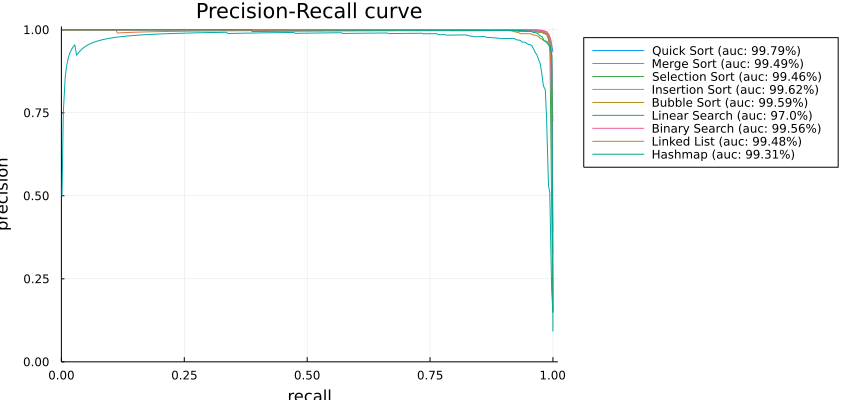

In [6]:
p = plot(size=(850, 400))

for (idx, label) ∈ enumerate(label_names)
    prplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false, legend=:outertopright)
end
savefig(p, "prcurve_augmented_wce.png")
p

For finding the optimal thresholds, we maximize the F1-score for each label

In [6]:
thresholds = 0.0:0.001:1.0 |> collect

change_nan(s) = isnan(s) ? 0 : s

for (idx, label) ∈ enumerate(label_names)
    f1_scores = thresholds .|> threshold -> f1_score(ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)) .|> change_nan
    jdx = argmax(f1_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(f1_scores[jdx])")
end

Quick Sort => 0.215 | score: 0.988173455978975
Merge Sort => 0.195 | score: 0.9887260428410373
Selection Sort => 0.347 | score: 0.9871504157218444
Insertion Sort => 0.602 | score: 0.9908592321755026
Bubble Sort => 0.496 | score: 0.9869807811531309
Linear Search => 0.808 | score: 0.9546632124352332
Binary Search => 0.681 | score: 0.9922879177377892
Linked List => 0.464 | score: 0.9763779527559056
Hashmap => 0.794 | score: 0.9786368260427263


Also, we can find the optimal decision boundaries using the ROC Curve

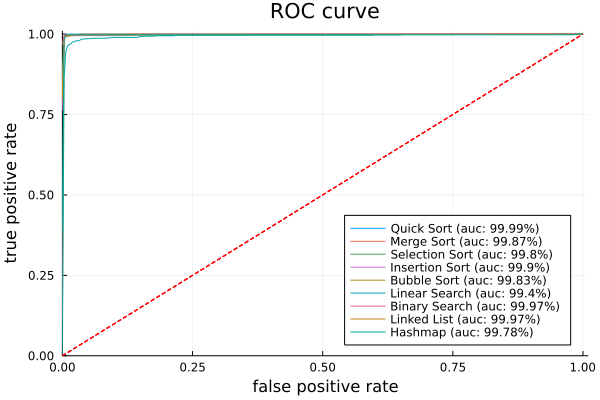

In [5]:
p = plot()

for (idx, label) ∈ enumerate(label_names)
    rocplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false)
end
savefig(p, "roccurve_augmented_wce.png")
p

We can find the optimal threshold using Youden's J Statistic

In [8]:
thresholds = 0.0:0.001:1.0 |> collect

j(sens, spec) = sens + spec - 1

for (idx, label) ∈ enumerate(label_names)
    confusion_matrices = thresholds .|> threshold -> ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
    j_scores = confusion_matrices .|> conf -> j(sensitivity(conf), specificity(conf))
    jdx = argmax(j_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(j_scores[jdx])")
end

Quick Sort => 0.052 | score: 0.9913573781987028
Merge Sort => 0.143 | score: 0.9890345242001479
Selection Sort => 0.197 | score: 0.9869372343128284
Insertion Sort => 0.304 | score: 0.9879041684584813
Bubble Sort => 0.248 | score: 0.9882362381640186
Linear Search => 0.182 | score: 0.9559801493085505
Binary Search => 0.151 | score: 0.9940788674200998
Linked List => 0.086 | score: 0.9900603428893273
Hashmap => 0.19 | score: 0.9902920734165019
